In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from scipy.stats import pearsonr

In [2]:
path = 'C:\\Users\\Asus\\Desktop'
data = pd.read_csv(f'{path}\\int20h-ds-test-dataset.csv')

In [3]:
data.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


Since our data is a sequence of events for many users, we will sort them chronologically

In [4]:
data['event_created_date'] = pd.to_datetime(data['event_created_date'])
data.sort_values('event_created_date', inplace=True)

In [5]:
print(f'There is {data.shape[0]} rows and {data.duplicated().sum()} duplicates')

There is 23357 rows and 1318 duplicates


In [6]:
# remove duplicates
data = data.drop_duplicates()

In [7]:
# check how many NaNs is in data
data.isna().sum()

userid                   0
user_state              71
event_name               0
event_attributes         0
event_created_date       0
event_platform           0
device_manufacture    6230
device_model          6230
dtype: int64

# At first, let's analyse, how events are related to cancelling subscription

Let's take a look at all events and their frequencies

In [8]:
data['event_name'].value_counts()

Order                                  4845
Sign Up Success                        3329
Add Vehicle Success                    1923
Account History Transaction Details    1607
Chat Conversation Opened               1485
Wallet Opened                          1471
Chat Conversation Started              1201
Add Payment Method Success             1038
Email Confirmation Success              832
Subscription Premium                    711
Calculator View                         620
Sign Out                                595
Account Setup Profile Skip              498
Add Vehicle Break                       486
Add Payment Method Failed               334
Subscription Premium Renew              310
Subscription Premium Cancel             262
Account Setup Skip                      222
Calculator Used                         120
Transaction Refund                      102
Sign Up Error                            26
Add Vehicle Failed                       21
Reset Password Set              

Since the last three events seem not very useful and appear very rarely, we remove them

In [9]:
data = data[~data['event_name'].isin(['Sign Up Error', 'Add Vehicle Failed', 'Reset Password Set'])]

Now we want to know, how $\textit{Subscription Premium}$  and $\textit{Subscription Premium Renew}$ events are related to $\textit{Subscription Cancel}$ 

We create a dataframe: rows - all users, columns - events from the list above. Value for a cell in a position (user, event) in the dataframe is equal to 1 if this event has been fired for this user and 0 otherwise.

In [10]:
# list with all user ids
ids = list(data['userid'].unique())
events = ['Subscription Premium', 'Subscription Premium Renew', 'Subscription Premium Cancel']
user_info = pd.DataFrame(data=np.zeros((len(ids), len(events))), index=ids, columns=events, dtype='int16')
for id in ids:
    event_sequence = list(data[data['userid'] == id]['event_name'])
    # we only take a time series before the subscription cancel event
    if 'Subscription Premium Cancel' in event_sequence:
        event_sequence = event_sequence[:event_sequence.index('Subscription Premium Cancel') + 1]
    for event in events:
        user_info.loc[id, event] = int(event in event_sequence)

In [11]:
user_info

,Subscription Premium,Subscription Premium Renew,Subscription Premium Cancel
50b02ade5133cc6c9da2573f5deb489e,0,0,0
779f1b3e348e1483627bc2010659920f,0,0,0
1ff8d11406caf7fa1a6280814860d526,0,0,0
c8d4d395f6b45f1ddd6ab9f29180f54a,0,1,0
18513686d0892dc983474752ca549f4c,0,0,0
...,...,...,...
d2c8e9fd8addde95536d13f61cbfb1cc,1,0,0
387c88f25e204376acf003420663fef5,1,0,1
6ebd67ba68c521c86d797a1c439d6de9,1,0,0
833489856a3cc8840d47a2c1cadda36d,1,0,0


Let's take a look at the users who don't have $\textit{Subscription Premium}$ and $\textit{Subscription Premium Renew}$ events:

In [12]:
user_info[(user_info['Subscription Premium'] == 0) & (user_info['Subscription Premium Renew'] == 0)]['Subscription Premium Cancel'].value_counts()

0    2745
1      18
Name: Subscription Premium Cancel, dtype: int64

Evidently, almost all of those users don't cancel subscriptions, probably, because they don't even have one.
Now we will analyze only those users, who have $\textit{Subscription Premium}$ or $\textit{Subscription Premium Renew}$ event

In [13]:
new_ids = list(user_info[(user_info['Subscription Premium'] == 1) | (user_info['Subscription Premium Renew'] == 1)].index)
print(f'There was {len(ids)} ids, remains only {len(new_ids)} of them')
ids = new_ids

There was 3539 ids, remains only 776 of them


For each id and each event we will calculate the number of occurrences of this event in a sequence, then calculate the correlation between these features and the target (target = 1 if the user canceled the subscription, otherwise 0)

In [14]:
events = [event for event in list(data['event_name'].unique()) if event != 'Subscription Premium Cancel']
user_info = pd.DataFrame(data=np.zeros((len(ids), len(events) + 1)), index=ids, columns=events + ['target'], dtype='int16')
for id in ids:
    event_sequence = list(data[data['userid'] == id]['event_name'])
    # we only take a time series before the subscription cancelation event
    if 'Subscription Premium Cancel' in event_sequence:
        event_sequence = event_sequence[:event_sequence.index('Subscription Premium Cancel') + 1]
        user_info.loc[id, 'target'] = 1
    for event in events:
        user_info.loc[id, event] = event_sequence.count(event)

In [15]:
user_info

,Wallet Opened,Sign Up Success,Add Vehicle Success,Account Setup Profile Skip,Email Confirmation Success,Account History Transaction Details,Sign Out,Add Vehicle Break,Chat Conversation Started,Chat Conversation Opened,Order,Add Payment Method Success,Subscription Premium,Calculator View,Account Setup Skip,Add Payment Method Failed,Transaction Refund,Calculator Used,Subscription Premium Renew,target
c8d4d395f6b45f1ddd6ab9f29180f54a,0,0,0,0,0,3,1,0,0,0,38,0,0,0,0,0,0,0,1,0
2467ce8593dd0efe1ce5d4b82263bc5c,0,0,3,0,0,0,1,0,0,0,5,1,1,0,0,0,0,0,0,0
a22abda7a39d747ab674cd13224b375a,3,1,1,2,0,9,0,0,0,0,0,1,1,0,0,0,0,0,0,1
f5988bc8ddb1a5733677d81109fe453b,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
41ef8ce6c7e3ce0869d791dc17a3d161,2,0,0,0,0,3,0,0,1,3,54,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d2c8e9fd8addde95536d13f61cbfb1cc,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
387c88f25e204376acf003420663fef5,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1
6ebd67ba68c521c86d797a1c439d6de9,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
833489856a3cc8840d47a2c1cadda36d,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [16]:
def display_correlations(corrs, title):
    corrs.sort_values(inplace=True)
    plt.figure(figsize=(10, 5 * len(corrs) // 10))
    plt.title(title)
    plt.barh(np.arange(len(corrs), 0, -1), corrs)
    plt.yticks(np.arange(len(corrs), 0, -1), corrs.index)
    plt.show()

In [17]:
correlations = pd.Series(index=events, dtype='float16')
for event in events:
    correlations[event] = pearsonr(user_info[event], user_info['target'])[0]

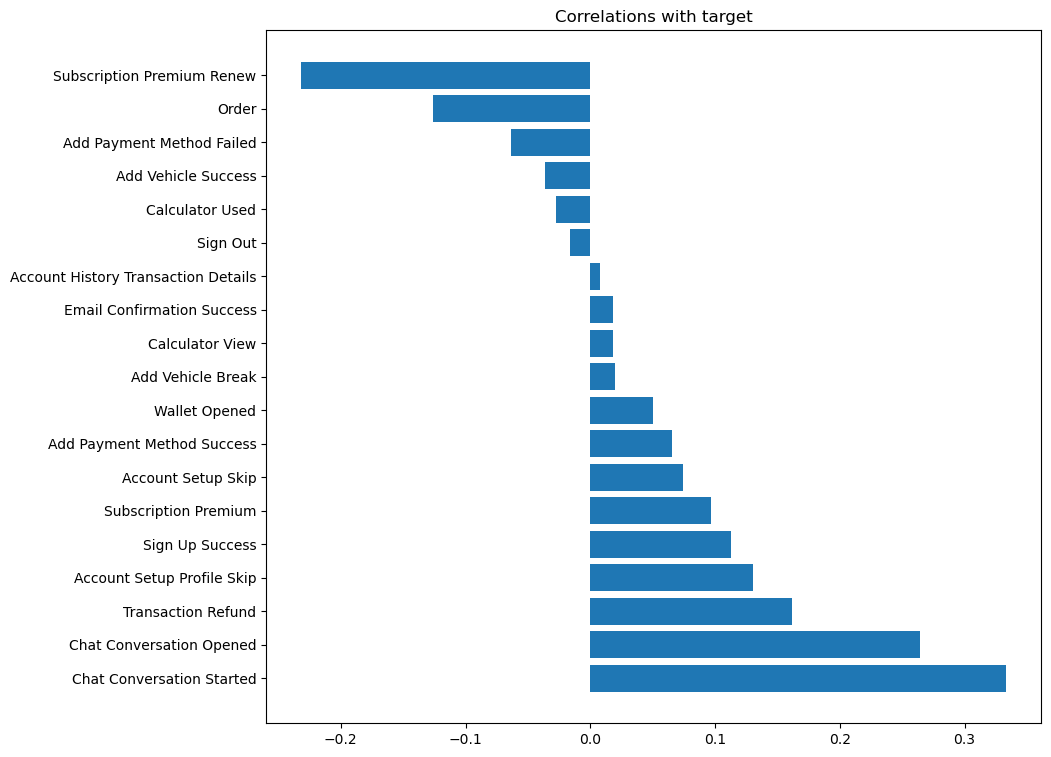

In [18]:
display_correlations(correlations, f'Correlations with target')

We can see that the events

$\textit{Subscription Premium Renew}$

$\textit{Order}$

have a correlation that is significantly lower than 0, so these events decrease the probability that a user will cancel the subscription.

On the other hand, these events:

$\textit{Chat Conversation Started}$

$\textit{Chat Conversation Opened}$

$\textit{Transaction Refund}$

$\textit{Account Profile Skip}$

have a correlation that is significantly higher than 0, so these events increase the probability that a user will cancel the subscription

# Now let's analyze how the $\textit{user_state}$ is related to cancelling the subscription 


In [19]:
# check if all users have only 1 state
id_count = 0
for id in ids:
    if data[data['userid'] == id]['user_state'].nunique() > 1:
        id_count += 1
        print(id, 'has more than 1 state')
if id_count == 0:
    print('All users have only 1 state')

All users have only 1 state


In [20]:
for id in ids:
    user_info.loc[id, 'user_state'] = list(data[data['userid'] == id]['user_state'])[0]

In [21]:
# let's take a look at all states and frequencies of their occurrence in the data
user_info['user_state'].value_counts()

CA    335
TX    185
FL     61
IL     40
NY     32
VA     25
NJ     17
MD      9
MA      8
PA      7
OK      6
IN      6
AZ      5
CT      4
NH      3
WI      3
NC      3
OH      3
DC      3
IA      2
KY      2
AR      2
CO      2
MI      1
AL      1
UT      1
DE      1
GA      1
NM      1
TN      1
KS      1
NV      1
VT      1
WV      1
OR      1
MT      1
Name: user_state, dtype: int64

We will analyse all states that have at least 40 users assigning all the others states to the category 'Other'. Users with absent states will be assigned to the 'Absent' category

In [22]:
big_states = []
for state in user_info['user_state'].unique():
    if (user_info['user_state'] == state).sum() >= 40:
        big_states.append(state)

In [23]:
for id in ids:
    if user_info.loc[id, 'user_state'] not in big_states:
        user_info.loc[id, 'user_state'] = 'Other'

In [24]:
# replace NaN values with the 'Other' category 
user_info['user_state'] = user_info['user_state'].fillna('Other')

CA       335
TX       185
Other    155
FL        61
IL        40
Name: user_state, dtype: int64


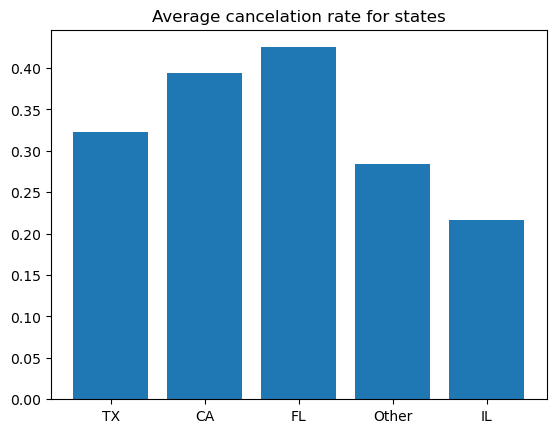

In [25]:
print(user_info['user_state'].value_counts())
plt.title('Average cancelation rate for states')
plt.bar(user_info['user_state'].unique(), user_info.groupby('user_state')['target'].mean())
plt.show()

From the chart above we can observe that the IL state has significantly lower cancelation rate, whilst Other and TX have slightly lower cancelation rate.

# Now let's analyse, how the $\textit{device_manufacture}$ is related to cancelling the subscription 

In [26]:
# check if all users have only 1 device_manufacture
id_count = 0
for id in ids:
    if data[data['userid'] == id]['device_manufacture'].nunique() > 1:
        id_count += 1
        print(id, 'has more than 1 device_manufacture')
if id_count == 0:
    print('All users have only 1 device_manufacture')

28368284a145474b2cc4961349bffcf3 has more than 1 device_manufacture
2a2003f6836b4720906cbae8893faec9 has more than 1 device_manufacture
107eea821b823c2218cc2f44fa7746d9 has more than 1 device_manufacture
46c1d5ea297bd502e2d7f9dba6056bdd has more than 1 device_manufacture
8cf789a4f14413c7ac58d3b6e8442cd0 has more than 1 device_manufacture
604062fd35365e259606987533396503 has more than 1 device_manufacture


As the majority of the users had the same device_manufacture during 2022 we will redefine the user's device_manufacture as such that is encountered the most frequently through the event sequence.


In [27]:
for id in ids:
    user_info.loc[id, 'device_manufacture'] = mode(list(data[data['userid'] == id]['device_manufacture']))

In [28]:
# let's take a look on all manufactures and their frequencies
user_info['device_manufacture'].value_counts()

Apple         394
samsung       170
motorola       24
LGE            15
Google         11
OnePlus         7
Wingtech        4
HMD Global      3
FIH             2
BLU             2
TCL             1
HUAWEI          1
vsmart          1
Name: device_manufacture, dtype: int64

Since only Apple and Samsung have many users, we will divide all users in three categories: Apple, Samsung and Other

In [29]:
for id in ids:
    if user_info.loc[id, 'device_manufacture'] not in ['Apple', 'samsung']:
        user_info.loc[id, 'device_manufacture'] = 'Other'

In [30]:
# fill cells with NaN values with the category 'Other'
user_info['device_manufacture'] = user_info['device_manufacture'].fillna('Other')

Apple      394
Other      212
samsung    170
Name: device_manufacture, dtype: int64


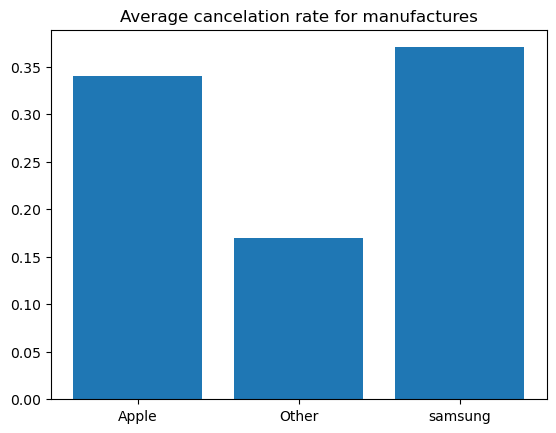

In [31]:
print(user_info['device_manufacture'].value_counts())
plt.title('Average cancelation rate for manufactures')
plt.bar(user_info.groupby('device_manufacture')['target'].mean().index, user_info.groupby('device_manufacture')['target'].mean())
plt.show()

From the chart above we can observe significantly lower cancelation rate for manufactures of the 'Other' category. Also it is worth to mention, that we have many different device_models, so we won't analyse them

# Now let's analyse, how the $\textit{event_platform}$ is related to cancelling the subscription 

In [32]:
# let's take a look on all manufactures and their frequencies
data['event_platform'].value_counts()

ios          9545
outofband    6230
android      6216
Name: event_platform, dtype: int64

For each user we will calculate, how many corresponding events occured on each platform

In [33]:
platforms = data['event_platform'].unique()
for platform in platforms:
    for id in ids:
        event_sequence = list(data[data['userid'] == id]['event_name'])
        event_platform = list(data[data['userid'] == id]['event_platform'])
        # we only take a time series before the subscription cancelation event
        if 'Subscription Premium Cancel' in event_sequence:
            event_sequence = event_sequence[:event_sequence.index('Subscription Premium Cancel') + 1]
            event_splatform = event_platform[:event_sequence.index('Subscription Premium Cancel') + 1]
        for platform in platforms:
            user_info.loc[id, platform] = event_platform.count(platform)

In [34]:
platform_correlations = pd.Series(index=platforms, dtype='float16')
for platform in platforms:
    platform_correlations[platform] = pearsonr(user_info[platform], user_info['target'])[0]

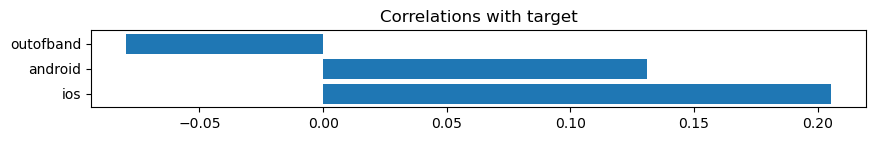

In [35]:
display_correlations(platform_correlations, f'Correlations with target')

Here we can see similar sutiation to device_manufacture

But, in fact, it's significant to mention that in our case, we need more additional information about the company for states analysis and the application for the analysis of user churn

# Finally, now we analyse $\textit{event_attributes}$ for each event

Here is list of all event attributes (which appear at least 100 times) with treir frequencies:

In [36]:
for event in events:
    attributes = data[data['event_name'] == event]['event_attributes'].apply(json.loads)
    df_attributes = pd.DataFrame(index=attributes.index, data=attributes.to_list())
    if df_attributes.shape[0] >= 100 and df_attributes.shape[1] > 0:
        print(event)
        print(list(df_attributes.columns))
        for attribute in df_attributes.columns:
            
            print(df_attributes[attribute].value_counts())
        print('---------------------------------------------------')
 

Sign Up Success
['Method']
Google      1504
Email       1017
Apple        586
Facebook     222
Name: Method, dtype: int64
---------------------------------------------------
Add Vehicle Success
['Make', 'Model', 'Color', 'Year', 'Temporary', 'Start Date', 'End Date', 'Rental state', 'Rental State']
Toyota          302
Honda           228
Ford            198
Chevrolet       180
Nissan          175
               ... 
freightliner      1
Take              1
Ford F 550        1
Frieghtliner      1
Hino              1
Name: Make, Length: 68, dtype: int64
Camry             78
Accord            72
Civic             61
Corolla           46
Altima            43
                  ..
moving truck       1
G Convertible      1
600LT              1
F-150 Heritage     1
Hino               1
Name: Model, Length: 434, dtype: int64
White     431
Black     408
Gray      315
Silver    276
Blue      189
Red       142
Other      62
Green      29
Brown      28
Beige      25
Orange      8
Gold        8
Yello

Since most of this attributes don't have much information (as an example, color of a vehicle), we decide to pick several attributes and check their impact on target

In [37]:
# key - event, value - attribute
split_events = {'Add Vehicle Success': 'Temporary',
                'Subscription Premium Renew': 'Membership Type',
               'Sign Out': 'Type',
               'Order': 'Premium Membership',
                'Add Payment Method Success': 'Payment Method'}

For each attribute we will split event for each possible value of its attribute and calculate correlations for all of them.
At first, let's update all events in new column upd_event_name

In [38]:
attributes_values = {}
attributes_events = []
data['upd_event_name'] = data['event_name']
for event in split_events:
    attribute = split_events[event]
    jsons = data[data['event_name'] == event]['event_attributes'].apply(json.loads)
    df_attributes = pd.DataFrame(data=jsons.to_list(), index=jsons.index)
    attributes_values[attribute] = []
    for att_type in df_attributes[attribute].unique():
        attributes_values[attribute].append(att_type)
        if att_type == att_type:
            indexes = df_attributes[df_attributes[attribute] == att_type].index
            data.loc[indexes, 'upd_event_name'] = f'{event}_{attribute}={att_type}'
            attributes_events.append(f'{event}_{attribute}={att_type}')

In [39]:
attributes_values

{'Temporary': ['false', 'true'],
 'Membership Type': ['Monthly', 'Yearly'],
 'Type': ['Manual', 'Auto'],
 'Premium Membership': ['True', 'False'],
 'Payment Method': ['PayPal', 'Debit', 'Credit', 'Venmo']}

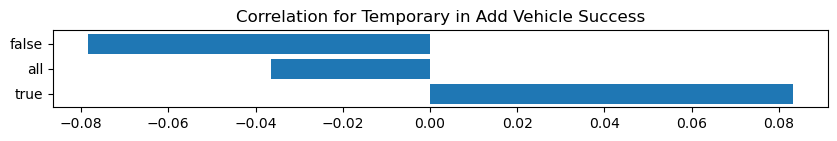

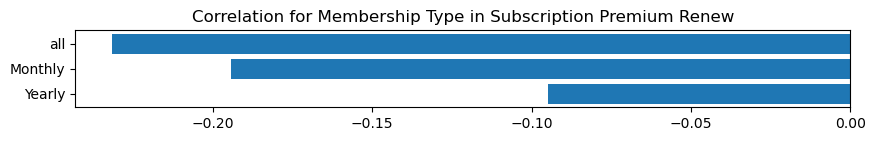

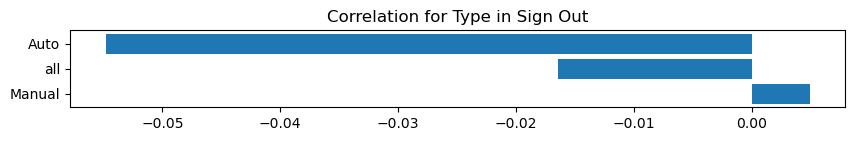

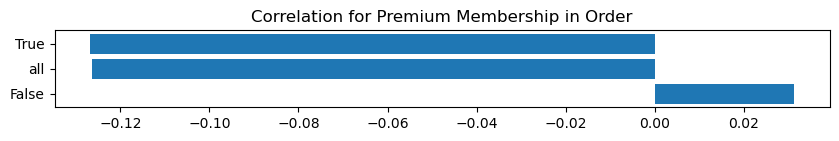

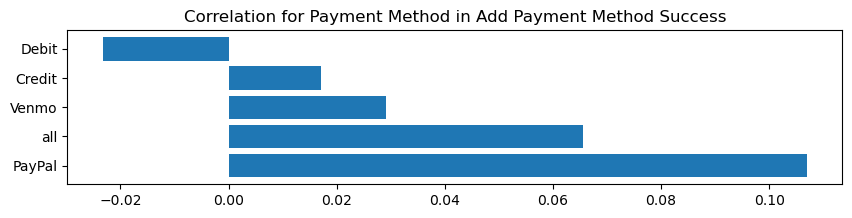

In [42]:
for event in split_events:
    attribute = split_events[event]
    correlations = pd.Series(dtype='float16')
    correlations.loc['all'] = pearsonr(user_info[event], user_info['target'])[0]
    for att_type in attributes_values[attribute]:
        for id in ids:
            event_sequence = list(data[data['userid'] == id]['upd_event_name'])
            if 'Subscription Premium Cancel' in event_sequence:
                event_sequence = event_sequence[:event_sequence.index('Subscription Premium Cancel') + 1]
            user_info.loc[id, f'{event}_{attribute}={att_type}'] = event_sequence.count(f'{event}_{attribute}={att_type}')
        correlations.loc[att_type] = pearsonr(user_info[f'{event}_{attribute}={att_type}'], user_info['target'])[0]
    display_correlations(correlations, f'Correlation for {attribute} in {event}')  

# In conclusion, this analysis gives us insights into the general nature of the data and will help us if we want to build a good ML model to predict user churn. Thanks for your attention!